<a href="https://colab.research.google.com/github/ZicoDiegoRR/my-sdxl-notebook-colab/blob/main/stable_diffusion_XL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###<font color="black"> » <b><font color="red">Installing Dependencies </b>💿</font> <font color="black"> «
#####ㅤRun this cell first before creating images!

In [ ]:
#@markdown <b>Run this first to install essential libraries!</b><br>
#@markdown <small><p>Required to use the generator.
from IPython.display import clear_output
print("📥 | Connecting to Google Drive...")
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
print("⚙️ | Downloading libraries...")
!pip install diffusers
!pip install torch==2.4.0 torchvision torchaudio
!pip install -U xformers --index-url https://download.pytorch.org/whl/cu121
!pip install transformers
!pip install accelerate
!pip install opencv-python
!pip install peft
!pip install --upgrade huggingface_hub
!pip install compel
!pip install controlnet-aux
!export PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True
print("📁 | All essential libraries have been downloaded.")
print("🖌 | You can start generating images now.")

📥 | Connecting to Google Drive...
Mounted at /content/gdrive
⚙️ | Downloading libraries...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 35.9 MB/s eta 0:00:00
Looking in indexes: https://download.pytorch.org/whl/cu121
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.8/20.8 MB 34.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.4/296.4 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 282.4/282.4 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.0/510.0 kB 33.8 MB/s eta 0:00:00
📁 | All essential libraries have been downloaded.
🖌 | You can start generating images now.


###<font color="black"> » <b><font color="orange">MultiControlNet<font color="black">, <b><font color="magenta"></b>IP-Adapter<font color="black">, and <b><font color="Lime">Inpainting</b> 🔧</font> <font color="black"> «

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

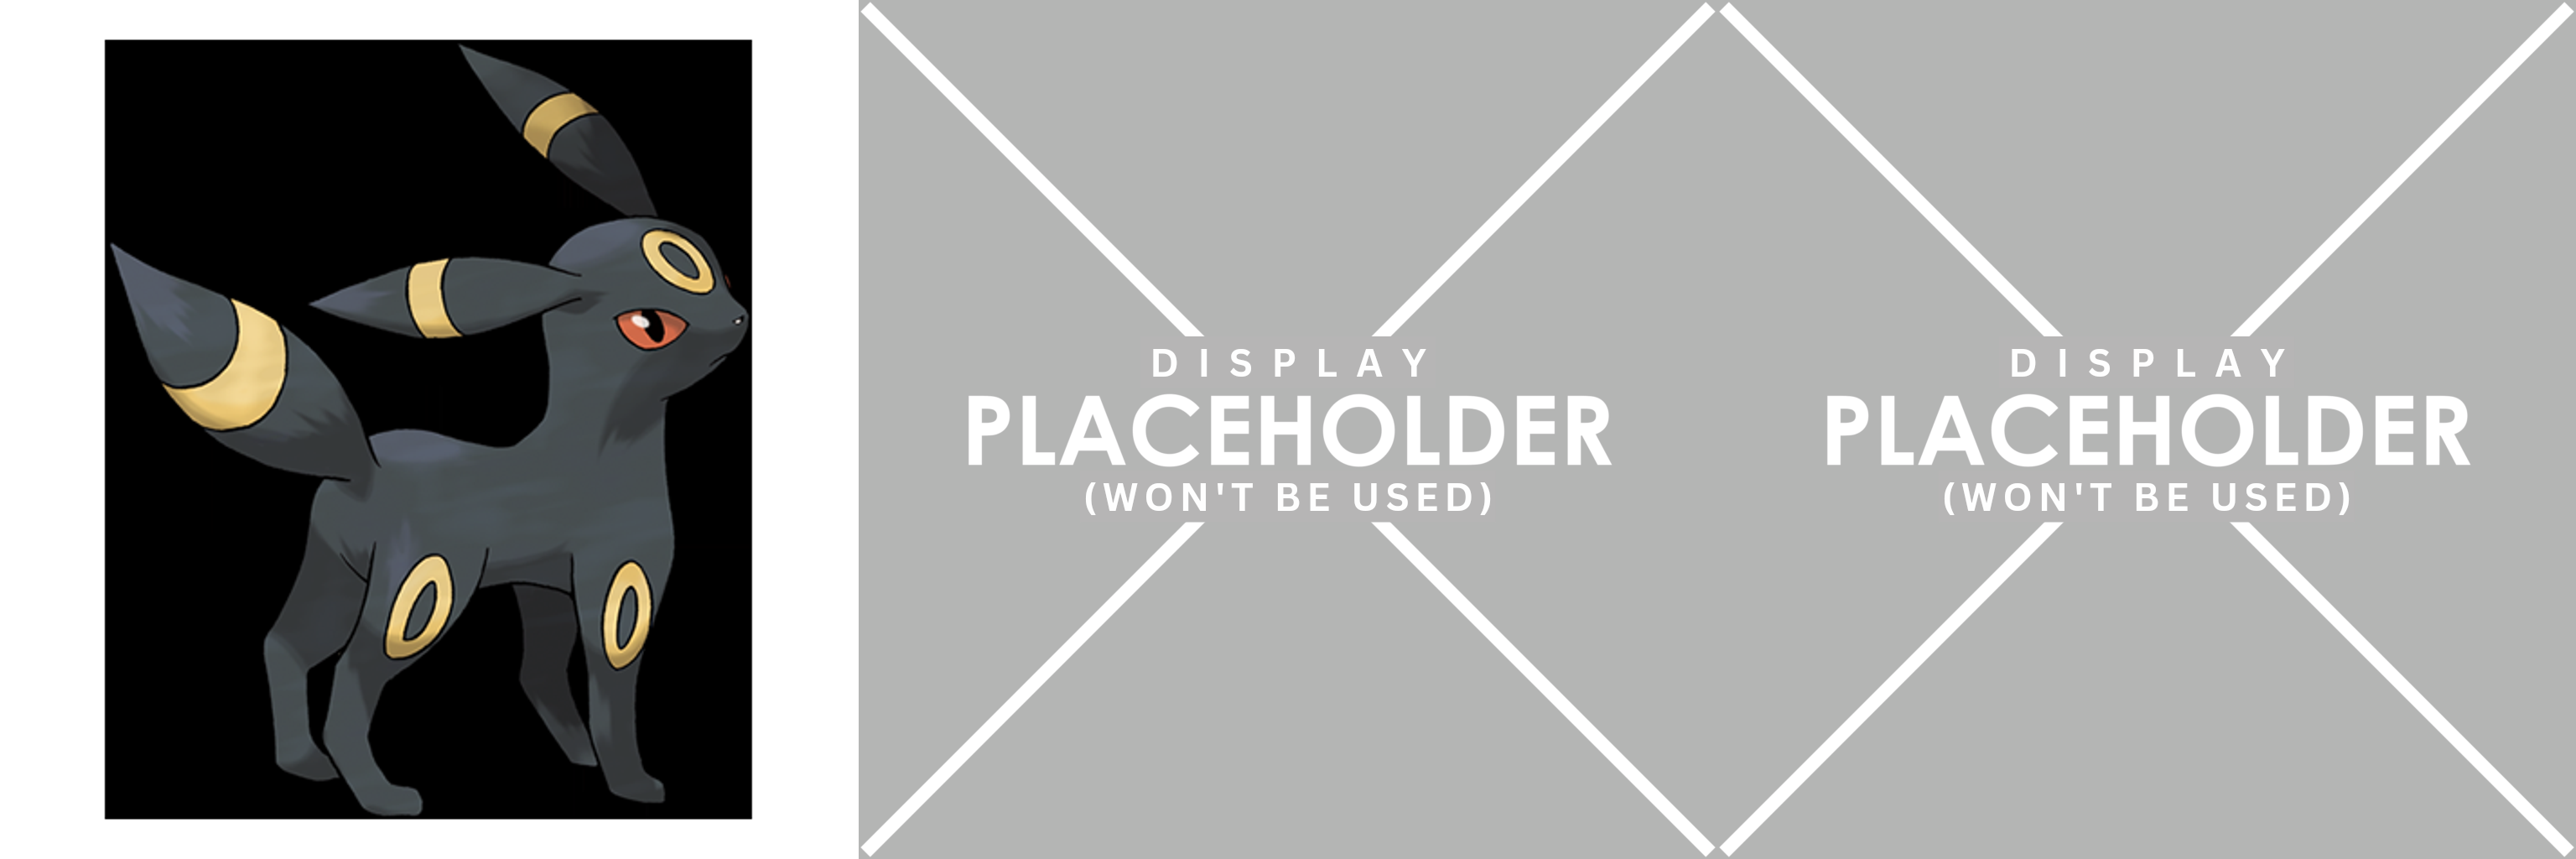

ValueError: `prompt_embeds` and `negative_prompt_embeds` must have the same shape when passed directly, but got: `prompt_embeds` torch.Size([1, 77, 768]) != `negative_prompt_embeds` torch.Size([1, 0, 77, 768]).

In [5]:
import cv2
import re
import numpy as np
from PIL import Image
from compel import Compel, ReturnedEmbeddingsType
from controlnet_aux import OpenposeDetector
from diffusers import ControlNetModel, AutoPipelineForText2Image, StableDiffusionXLPipeline, UniPCMultistepScheduler, StableDiffusionXLControlNetPipeline, AutoPipelineForInpainting, AutoencoderKL, DiffusionPipeline, StableDiffusionControlNetPipeline
from diffusers.utils import load_image, make_image_grid
from huggingface_hub import login
from transformers import pipeline as pipe
from transformers import CLIPVisionModelWithProjection
import time
import os
import subprocess
import os.path
import torch
import random
import json

# Function to load the saved number from a file
def load_number(filename):
    try:
        with open(filename, 'r') as file:
            data = json.load(file)
            return data['number']
    except (FileNotFoundError, KeyError):
        return None

# Function to save the number to a file
def save_number(filename, number):
    with open(filename, 'w') as file:
        json.dump({'number': number}, file)
def get_depth_map(image, depth_estimator):
    image = depth_estimator(image)["depth"]
    image = np.array(image)
    image = image[:, :, None]
    image = np.concatenate([image, image, image], axis=2)
    detected_map = torch.from_numpy(image).float() / 255.0
    depth_map = detected_map.permute(2, 0, 1)
    return depth_map
def get_depth_map_display(image, depth_estimator):
    image = depth_estimator(image)["depth"]
    image = np.array(image)
    image = image[:, :, None]
    image = np.concatenate([image, image, image], axis=2)
    return image
# Main function to handle the logic
if __name__ == "__main__":

    torch.backends.cudnn.benchmark=True
    os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:16"
    os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
    folder = "/content/gdrive/MyDrive/"
    filename = os.path.join(folder, "random_number.json")
    Freeze = False #@param {type:"boolean"}
    saved_number = load_number(filename)
    if not Freeze:
        # Generate a new random number if Freeze is False
        random_number = random.randint(1, 1000000000)
        save_number(filename, random_number)
        saved_number = load_number(filename)
    else:
        # Use the saved number if Freeze is True
        if saved_number is not None:
            saved_number = saved_number
        else:
            print("No saved number found. Please set Freeze to False to generate a new number first.")

    #@markdown ***
    #@markdown <b>Image Generation Prompt 🖌</b><br>
    #@markdown <small>What do you want to see from the image?</small><br>
    #@markdown <small>Leave everything unchecked and set the IP-Adapter to "None" to generate using Text2Image pipeline.</small>
    Prompt = "umbreon" #@param {type:"string"}
    #@markdown <small> Currently supports HuggingFace and CivitAI models, but also works for any websites. For HuggingFace's model, provide only the repository's ID. For CivitAI and others, provide the direct link to the model. When you're getting 401 error from CivitAI's link, add your token below.</small>
    Model_Version = "Stable Diffusion 1" #@param ["Stable Diffusion 1", "Stable Diffusion XL 1.0"]
    Model = "IDK-ab0ut/Yiffymix_v43" #@param {type:"string"}
    Model_Format = "Safe Tensor (.safetensors)" #@param ["Pickle Tensor (.ckpt)", "Safe Tensor (.safetensors)"]
    #@markdown ***
    #@markdown <b>Image Generation Settings ⚙️</b><br>
    #@markdown <small>Leave "ip" to use last pre-generated ControlNet image. Check the box and leave the link blank to use last pre-generated image. </small>
    Width = 1024 #@param {type:"slider", min: 512, max:1536, step:64}
    Height = 1024 #@param {type:"slider", min:512, max:1536, step:64}
    Steps = 28 #@param {type:"number"}
    Scale = 8 #@param {type:"slider", min:1, max:12, step:0.1}
    #@markdown <small> Only accepts one link for Variational Autoencoder. </small>
    VAE_Link = "" #@param {type:"string"}
    #@markdown ***
    #@markdown <b> LoRA</b> 📁🖌️

    #@markdown <small> You can use multiple direct links to the LoRAs using this format: </small>

    #@markdown <font color="blue"><u><small><small> <link/to/file.safetensors>, <link/to/file.bin>, ... </small></small></font></u>

    #@markdown <small> Make sure to put a space (or not) between comma and the next link. </small>
    LoRA_URLs = "" #@param {type:"string"}
    #@markdown <small> Same as the URLs. </small>
    #@markdown <small> The first numbers represent the weight's scale for the first LoRA you just inputted. The logic also applies to every LoRA. </small>
    Weight_Scale = "" #@param {type:"string"}
    #@markdown <small> Passing CivitAI's token is optional, but required if you're getting 401 Unauthorized error. Do not share your CivitAI's API key to anyone else!</small>
    Token = "" #@param {type:"string"}
    #@markdown ***
    #@markdown <b>ControlNet</b> 🖼️🔧

    #@markdown <small> Adjust the thresholds based on your needs. Put an image link to the <b> Canny_Link </b> for reference. </small>
    minimum_canny_threshold = 230 #@param {type:"slider", min:10, max:500, step:5}
    maximum_canny_threshold = 300 #@param {type:"slider", min:100, max:750, step:5}
    Canny_Link = "" #@param {type:"string"}
    Canny = False #@param {type:"boolean"}
    Canny_Strength = 0.8 #@param {type:"slider", min:0.1, max:1, step:0.1}
    #@markdown ————————————————————————
    #@markdown <small> Put an image link to the <b> DepthMap_Link </b> for reference. </small>
    DepthMap_Link = "" #@param {type:"string"}
    Depth_Map = False #@param {type:"boolean"}
    Depth_Strength = 0.8 #@param {type:"slider", min:0.1, max:1, step:0.1}
    #@markdown ————————————————————————
    #@markdown <small> Put an image link to the <b> OpenPose_Link </b> for reference. </small>
    OpenPose_Link = "" #@param {type:"string"}
    Open_Pose = False #@param {type:"boolean"}
    Open_Pose_Strength = 0.7 #@param {type:"slider", min:0.1, max:1, step:0.1}
    #@markdown ***
    #@markdown <b>Inpainting</b> 🖼️🖌️

    #@markdown <small> Set the <b>Inpainting_Image</b> to "pre-generated text2image image" for last generated Text2Image image, "pre-generated controlnet image" for last ControlNet's generated image, and "previous inpainting image" for last inpainted image. Or you can pick image online using its direct link.</small>
    Inpainting_Image = "" #@param ["pre-generated text2image image", "pre-generated controlnet image", "previous inpainting image"] {allow-input:true}
    Mask_Image = "" #@param {type:"string"}
    Inpainting = False #@param {type:"boolean"}
    Inpainting_Strength = 0.9 #@param {type:"slider", min:0.1, max:1, step:0.1}
    #@markdown ***
    #@markdown <b>IP-Adapter</b> 🖼️📝

    #@markdown <small> You can use multiple direct links to the images using this format: </small>

    #@markdown <small><small><small> https://example1.com/.../file.jpg, https://example2.com/.../file.jpg, ... </small></small></small>

    #@markdown <small> Make sure to put a space between comma and the next link. </small>
    IP_Adapter = "ViT-G or ViT-H" #@param ["Plus", "Face", "ViT-G or ViT-H", "None"]
    IP_Image_Link="https://www.pokemon.com/static-assets/content-assets/cms2/img/pokedex/full/197.png" #@param {type:"string"}
    IP_Adapter_Strength= 1 #@param {type:"slider", min:0.1, max:1, step:0.1}
    #@markdown ***
    #@markdown <b>Image Generation Negative Prompt ⛔</b><br>
    #@markdown <small>What you <b>don't</b> want to see from the image? (optional)</small><br>
    Negative_Prompt = "bad quality, worst quality " #@param {type:"string"}
    if Canny:
        if Canny_Link == "ip":
            Canny_link = "/content/gen_2.jpg"
        elif not Canny_Link:
            Canny_link = "/content/gen.jpg"
        else:
            Canny_link = Canny_Link
    if Depth_Map:
        if DepthMap_Link == "ip":
            Depthmap_Link = "/content/gen_2.jpg"
        elif not DepthMap_Link:
            Depthmap_Link = "/content/gen.jpg"
        else:
            Depthmap_Link = DepthMap_Link
    if Open_Pose:
        if OpenPose_Link == "ip":
            Openpose_Link = "/content/gen_2.jpg"
        elif not OpenPose_Link:
            Openpose_Link = "/content/gen.jpg"
        else:
            Openpose_Link = OpenPose_Link
    if Inpainting:
        if Canny or Depth_Map or Open_Pose:
            raise TypeError("You checked both ControlNet and Inpainting, which will cause incompatibility issues during your run. As of now, there's no alternative way to merge StableDiffusionXLControlNetPipeline and StableDiffusionXLInpaintingPipeline without causing any issues. Perhaps you want to use only one of them?")
        if not Mask_Image:
            raise ValueError("You checked Inpainting while you're leaving Mask_Image empty. Mask_Image is required for Inpainting!")
        else:
            mask_image = load_image(Mask_Image).resize((1024, 1024))
        if Inpainting_Image == "pre-generated text2image image":
            inpaint_image = load_image("/content/gen.jpg").resize((1024, 1024))
        elif Inpainting_Image == "pre-generated controlnet image":
            inpaint_image = load_image("/content/gen_2.jpg").resize((1024, 1024))
        elif Inpainting_Image == "previous inpainting image":
            inpaint_image = load_image("/content/gen_3.jpg")
        else:
            inpaint_image = load_image(Inpainting_Image)
        display(make_image_grid([inpaint_image, mask_image], rows=1, cols=2))
    if not IP_Image_Link and IP_Adapter != "None":
        raise ValueError(f"You selected {IP_Adapter}, but left the IP_Image_Link empty. Please change the IP_Adapter to None or add at least one image in IP_Image_Link!")
    if Model_Version == "Stable Diffusion 1":
        version = "1"
        image_encoder_path = "sdxl_models/image_encoder"
    elif Model_Version == "Stable Diffusion XL 1.0":
        version = "xl"
        image_encoder_path = "models/image_encoder"
    if IP_Adapter != "None":
        sdxl_adapter = ["ip-adapter-plus_sdxl_vit-h.bin", "ip-adapter-plus-face_sdxl_vit-h.bin", "ip-adapter_sdxl_vit-h.bin"]
        sd_adapter = ["ip-adapter-plus_sd15.bin", "ip-adapter-plus-face_sd15.bin", "ip-adapter_sd15_vit-G.bin"]
        ip_model = 0 if IP_Adapter == "Plus" else 1 if IP_Adapter == "Face" else 2
        ip_adapter = sdxl_adapter[ip_model] if version == "xl" else sd_adapter[ip_model]
        ip_folder = "models" if version == "1" else "sdxl_models"
    controlnets = []
    images = []
    controlnets_scale = []
    if Canny:
        controlnets.append(ControlNetModel.from_pretrained("diffusers/controlnet-canny-sdxl-1.0", torch_dtype=torch.float16, use_safetensors=True).to("cuda"))
        print("🏞️ | Converting image with Canny Edge Detection...")
        c_img = load_image(Canny_link)
        image_canny = np.array(c_img)
        image_canny = cv2.Canny(image_canny, minimum_canny_threshold, maximum_canny_threshold)
        image_canny = image_canny[:, :, None]
        image_canny = np.concatenate([image_canny, image_canny, image_canny], axis=2)
        canny_image = Image.fromarray(image_canny)
        print("✅ | Canny Edge Detection is complete.")
        time.sleep(1)
        display(make_image_grid([c_img, canny_image], rows=1, cols=2))
        images.append(canny_image.resize((1024, 1024)))
        controlnets_scale.append(Canny_Strength)
    if Depth_Map:
        controlnets.append(ControlNetModel.from_pretrained("diffusers/controlnet-depth-sdxl-1.0", torch_dtype=torch.float16, use_safetensors=True).to("cuda"))
        print("🏞️ | Converting image with Depth Map...")
        image_depth = load_image(Depthmap_Link).resize((1024, 1024))
        depth_estimator = pipe("depth-estimation")
        depth_map = get_depth_map(image_depth, depth_estimator).unsqueeze(0).half().to("cpu")
        images.append(depth_map)
        depth_map_display = Image.fromarray(get_depth_map_display(image_depth, depth_estimator))
        print("✅ | Depth Map is complete.")
        controlnets_scale.append(Depth_Strength)
        time.sleep(1)
        display(make_image_grid([image_depth, depth_map_display], rows=1, cols=2))
    if Open_Pose:
        openpose = OpenposeDetector.from_pretrained("lllyasviel/ControlNet").to("cpu")
        controlnets.append(ControlNetModel.from_pretrained("thibaud/controlnet-openpose-sdxl-1.0", torch_dtype=torch.float16).to("cuda"))
        print("🏞️ | Converting image with Open Pose...")
        image_openpose = load_image(Openpose_Link)
        openpose_image = openpose(image_openpose)
        images.append(openpose_image.resize((1024, 1024)))
        print("✅ | Open Pose is done.")
        controlnets_scale.append(Open_Pose_Strength)
        display(make_image_grid([image_openpose, openpose_image], rows=1, cols=2))
    image_encoder = CLIPVisionModelWithProjection.from_pretrained(
        "h94/IP-Adapter",
        subfolder=image_encoder_path,
        torch_dtype=torch.float16,
    )
    if VAE_Link:
        if not os.path.exists("/content/VAE"):
            os.mkdir("VAE")
        if version == "1":
            VAE_cfg = "https://huggingface.co/pt-sk/stable-diffusion-1.5/resolve/main/vae/config.json"
        elif version == "xl":
            VAE_cfg = "https://huggingface.co/stabilityai/stable-diffusion-xl-base-1.0/resolve/main/vae/config.json"
        os.system(f'cd /content/VAE; wget -O vae.safetensors "{VAE_Link}"')
        os.system(f'cd /content/VAE; wget -N "{VAE_cfg}"')
        vae = AutoencoderKL.from_single_file("/content/VAE/vae.safetensors", torch_dtype=torch.float16, config="/content/VAE/config.json", local_files_only=True)
    if "http" not in Model:
        if not Canny and not Depth_Map and not Open_Pose and not Inpainting:
            if VAE_Link:
                pipeline = AutoPipelineForText2Image.from_pretrained(Model, image_encoder=image_encoder, vae=vae, torch_dtype=torch.float16).to("cuda")
            else:
                pipeline = StableDiffusionXLPipeline.from_pretrained(Model, image_encoder=image_encoder, torch_dtype=torch.float16).to("cuda")
        elif Inpainting and not Canny and not Depth_Map and not Open_Pose:
            if VAE_Link:
                pipeline = AutoPipelineForInpainting.from_pretrained(Model, image_encoder=image_encoder, vae=vae, torch_dtype=torch.float16).to("cuda")
            else:
                pipeline = AutoPipelineForInpainting.from_pretrained(Model, image_encoder=image_encoder, torch_dtype=torch.float16).to("cuda")
        else:
            if VAE_Link:
                if version == "1":
                    pipeline = StableDiffusionXLControlNetPipeline.from_pretrained(Model, image_encoder=image_encoder, controlnet=controlnets, vae=vae, torch_dtype=torch.float16).to("cuda")
                elif version == "xl":
                    pipeline = StableDiffusionControlNetPipeline.from_pretrained(Model, image_encoder=image_encoder, vae=vae, controlnet=controlnets, torch_dtype=torch.float16).to("cuda")
            else:
                if version == "1":
                    pipeline = StableDiffusionXLControlNetPipeline.from_pretrained(Model, image_encoder=image_encoder, controlnet=controlnets, torch_dtype=torch.float16).to("cuda")
                elif version == "xl":
                    pipeline = StableDiffusionControlNetPipeline.from_pretrained(Model, image_encoder=image_encoder, controlnet=controlnets, torch_dtype=torch.float16).to("cuda")
    else:
        if not os.path.exists("/content/Checkpoint"):
            os.mkdir("Checkpoint")
        if ".ckpt" in Model_Format:
            format = ".ckpt"
        elif ".safetensors" in Model_Format:
            format = ".safetensors"
        checkpoint_name = f"checkpoint_model{format}"
        if Token and "civitai.com" in Model:
            if "?" in Model or "&" in Model:
                checkpoint_link = f"{Model}&token={Token}"
            else:
                checkpoint_link = f"{Model}token={Token}"
        else:
            checkpoint_link = Model
        Model_folder = checkpoint_link.replace("/", "_")
        Model_path = f"/content/Checkpoint/{Model_folder}/{checkpoint_name}"
        Model_path_folder = f"/content/Checkpoint/{Model_folder}"
        if not os.path.exists(Model_path_folder):
            os.mkdir(Model_path_folder)
            !cd "$Model_path_folder"; wget -O "$checkpoint_name" "$checkpoint_link"
        if not Canny and not Depth_Map and not Open_Pose and not Inpainting:
            if VAE_Link:
                if version == "xl":
                    pipeline = StableDiffusionXLPipeline.from_single_file(Model_path, image_encoder=image_encoder, vae=vae, torch_dtype=torch.float16).to("cuda")
                elif version == "1":
                    pipeline = StableDiffusionPipeline.from_single_file(Model_path, image_encoder=image_encoder, vae=vae, torch_dtype=torch.float16).to("cuda")
            else:
                if version == "xl":
                    pipeline = StableDiffusionXLPipeline.from_single_file(Model_path, image_encoder=image_encoder, torch_dtype=torch.float16).to("cuda")
                elif version == "1":
                    pipeline = DiffusionPipeline.from_single_file(Model_path, image_encoder=image_encoder, torch_dtype=torch.float16).to("cuda")
        elif Inpainting and not Canny and not Depth_Map and not Open_Pose:
            if VAE_Link:
                pipeline = AutoPipelineForInpainting.from_single_file(Model_path, image_encoder=image_encoder, vae=vae, torch_dtype=torch.float16).to("cuda")
            else:
                pipeline = AutoPipelineForInpainting.from_single_file(Model_path, image_encoder=image_encoder, torch_dtype=torch.float16).to("cuda")
        else:
            if VAE_Link:
                if version == "xl":
                    pipeline = StableDiffusionXLControlNetPipeline.from_single_file(Model_path, image_encoder=image_encoder, controlnet=controlnets, vae=vae, torch_dtype=torch.float16).to("cuda")
                if version == "1":
                    pipeline = StableDiffusionControlNetPipeline.from_single_file(Model_path, image_encoder=image_encoder, controlnet=controlnets, vae=vae, torch_dtype=torch.float16).to("cuda")
            else:
                if version == "xl":
                    pipeline = StableDiffusionXLControlNetPipeline.from_single_file(Model_path, image_encoder=image_encoder, controlnet=controlnets, torch_dtype=torch.float16).to("cuda")
                if version == "1":
                    pipeline = StableDiffusionControlNetPipeline.from_single_file(Model_path, image_encoder=image_encoder, controlnet=controlnets, torch_dtype=torch.float16).to("cuda")
    pipeline.enable_xformers_memory_efficient_attention()
    generator = torch.Generator("cpu").manual_seed(saved_number)
    pipeline.safety_checker = None
    pipeline.scheduler = UniPCMultistepScheduler.from_config(pipeline.scheduler.config)
    if version == "xl":
        compel = Compel(tokenizer=[pipeline.tokenizer, pipeline.tokenizer_2], text_encoder=[pipeline.text_encoder, pipeline.text_encoder_2], returned_embeddings_type=ReturnedEmbeddingsType.PENULTIMATE_HIDDEN_STATES_NON_NORMALIZED, requires_pooled=[False, True], truncate_long_prompts=False)
        conditioning, pooled = compel([Prompt, Negative_Prompt])
    elif version == "1":
        compel = Compel(tokenizer=pipeline.tokenizer, text_encoder=pipeline.text_encoder, returned_embeddings_type=ReturnedEmbeddingsType.PENULTIMATE_HIDDEN_STATES_NON_NORMALIZED, requires_pooled=False, truncate_long_prompts=False)
        conditioning, pooled = compel([Prompt, Negative_Prompt])
        [conditioning,pooled]=compel.pad_conditioning_tensors_to_same_length([conditioning, pooled])
    if LoRA_URLs:
        lora_list = []
        lora_path = []
        lora_links = re.split(r", h", LoRA_URLs.replace(", http", ", hhttp").replace(",http", ", hhttp").replace(", /c", ", h/c").replace(",/c", ", h/c"))
        if not os.path.exists("/content/LoRAs"):
            os.mkdir("LoRAs")
        if not Weight_Scale:
            scales_string = ["1"] * len(lora_links)
        elif Weight_Scale and len(re.split(r",| ,", Weight_Scale)) < len(lora_links):
            scales_string = re.split(r",| ,", Weight_Scale)
            for j in range(len(lora_links) - len(scales_string)):
                scales_string.append("1")
        else:
            scales_string = re.split(r",| ,", Weight_Scale)
        scales = [float(num) for num in scales_string]

        for i, link in enumerate(lora_links, start=1):
            path_file = os.path.join("/content/LoRAs", link.replace("/", "_").replace(".", "_"))
            if not os.path.exists(path_file) and "http" in link:
                os.makedirs(path_file)
            lora_name = link.replace("/", "_").replace(".", "_")
            lora_file_name = f"lora_{lora_name}.safetensors"
            if "civitai.com" in link and Token:
                if "&" in link or "?" in link:
                    civit_link = f"{link}&token={Token}"
                else:
                    civit_link = f"{link}?token={Token}"
                if not os.path.isfile(os.path.join(path_file, lora_file_name)):
                    !cd "$path_file"; wget -O "$lora_file_name" "$civit_link"
                lora_list.append(lora_file_name)
                lora_path.append(path_file)
            elif link.startswith("http"):
                if not os.path.isfile(os.path.join(path_file, lora_file_name)):
                    !cd "$path_file"; wget -O "$lora_file_name" "$link"
                lora_list.append(lora_file_name)
                lora_path.append(path_file)
            else:
                if link.startswith("/content/gdrive/MyDrive"):
                    constructed_gdrive_link = link
                else:
                    constructed_gdrive_link = f"/content/gdrive/MyDrive/{link}"
                link_from_gdrive = constructed_gdrive_link.split("/")
                lora_path.append("/".join([word for word in link_from_gdrive if ".safetensors" not in word]))
                lora_list.append(link_from_gdrive[-1])
        lora_weights = [word for word in lora_list if word.endswith(".safetensors")]
        print(lora_weights)
        lora_names = [word.replace(".safetensors", "") for word in lora_weights]
        for p in range(len(lora_weights)):
            pipeline.load_lora_weights(f"{lora_path[p]}/{lora_weights[p]}", adapter_name=lora_names[p])
        pipeline.set_adapters(lora_names, adapter_weights=scales)
    torch.cuda.empty_cache()
    if IP_Adapter != "None":
        adapter_image = []
        simple_Url = IP_Image_Link.split(", ")
        for link in simple_Url:
            adapter_image.append(load_image(link))
        adapter_display = [element for element in adapter_image]
        if len(adapter_display) % 3 == 0:
            row = len(adapter_display)/3
        else:
            row = int(len(adapter_display)/3) + 1
            for i in range(3*row - len(adapter_display)):
                adapter_display.append(load_image("https://huggingface.co/IDK-ab0ut/BFIDIW9W29NFJSKAOAOXDOKERJ29W/resolve/main/placeholder.png"))
        display(make_image_grid([element.resize((1024, 1024)) for element in adapter_display], rows=row, cols=3))
        image_embeds = [adapter_image]
        pipeline.load_ip_adapter("h94/IP-Adapter", subfolder=ip_folder, weight_name=ip_adapter)
        pipeline.set_ip_adapter_scale(IP_Adapter_Strength)
    torch.cuda.empty_cache()
    if version == "1":
        if not Canny and not Depth_Map and not Open_Pose and not Inpainting:
            image_save = "/content/gen.jpg"
            if IP_Adapter == "None":
                image = pipeline(prompt_embeds=conditioning[0:1], pooled_prompt_embeds=pooled[0:1],negative_prompt_embeds=conditioning[1:2], negative_pooled_prompt_embeds=pooled[1:2],num_inference_steps=Steps, width=Width, height=Height, guidance_scale=Scale, clip_skip=2, generator=generator).images[0]
            else:
                image = pipeline(prompt_embeds=conditioning[0:1], pooled_prompt_embeds=pooled[0:1],negative_prompt_embeds=conditioning[1:2], negative_pooled_prompt_embeds=pooled[1:2],num_inference_steps=Steps, ip_adapter_image=image_embeds, width=Width, height=Height, guidance_scale=Scale, clip_skip=2, generator=generator).images[0]
                pipeline.unload_ip_adapter()
        elif Inpainting and not Canny and not Depth_Map and not Open_Pose:
            image_save = "/content/gen_3.jpg"
            if IP_Adapter == "None":
                image = pipeline(prompt_embeds=conditioning[0:1], pooled_prompt_embeds=pooled[0:1],negative_prompt_embeds=conditioning[1:2], negative_pooled_prompt_embeds=pooled[1:2],num_inference_steps=Steps, width=Width, height=Height, guidance_scale=Scale, clip_skip=2, image=inpaint_image, mask_image=mask_image, generator=generator,strength=Inpainting_Strength).images[0]
            else:
                image = pipeline(prompt_embeds=conditioning[0:1], pooled_prompt_embeds=pooled[0:1],negative_prompt_embeds=conditioning[1:2], negative_pooled_prompt_embeds=pooled[1:2],num_inference_steps=Steps, ip_adapter_image=image_embeds, width=Width, height=Height, guidance_scale=Scale, clip_skip=2, generator=generator, image=inpaint_image, mask_image=mask_image, strength=Inpainting_Strength).images[0]
                pipeline.unload_ip_adapter()
        else:
            image_save = "/content/gen_2.jpg"
            if Inpainting:
                if IP_Adapter == "None":
                    image = pipeline(
                        prompt_embeds=conditioning[0:1],
                        pooled_prompt_embeds=pooled[0:1],
                        negative_prompt_embeds=conditioning[1:2],
                        negative_pooled_prompt_embeds=pooled[1:2],
                        clip_skip=2,
                        num_inference_steps=Steps,
                        generator=generator,
                        width=Width,
                        height=Height,
                        image=images,
                        controlnet_conditioning_scale=controlnets_scale,
                        guidance_scale=Scale,
                    ).images[0]
                else:
                    image = pipeline(
                        prompt_embeds=conditioning[0:1],
                        pooled_prompt_embeds=pooled[0:1],
                        negative_prompt_embeds=conditioning[1:2],
                        negative_pooled_prompt_embeds=pooled[1:2],
                        num_inference_steps=Steps,
                        ip_adapter_image=image_embeds,
                        width=Width,
                        height=Height,
                        guidance_scale=Scale,
                        clip_skip=2,
                        generator=generator,
                        image=images,
                        controlnet_conditioning_scale=controlnets_scale,
                    ).images[0]
            else:
                if IP_Adapter == "None":
                    image = pipeline(
                        prompt_embeds=conditioning[0:1],
                        pooled_prompt_embeds=pooled[0:1],
                        negative_prompt_embeds=conditioning[1:2],
                        negative_pooled_prompt_embeds=pooled[1:2],
                        clip_skip=2,
                        num_inference_steps=Steps,
                        generator=generator,
                        width=Width,
                        height=Height,
                        image=images,
                        controlnet_conditioning_scale=controlnets_scale,
                        guidance_scale=Scale,
                    ).images[0]
                else:
                    image = pipeline(
                        prompt_embeds=conditioning[0:1],
                        pooled_prompt_embeds=pooled[0:1],
                        negative_prompt_embeds=conditioning[1:2],
                        negative_pooled_prompt_embeds=pooled[1:2],
                        num_inference_steps=Steps,
                        ip_adapter_image=image_embeds,
                        width=Width,
                        height=Height,
                        guidance_scale=Scale,
                        clip_skip=2,
                        generator=generator,
                        image=images,
                        controlnet_conditioning_scale=controlnets_scale
                    ).images[0]
    if version == "xl":
        if not Canny and not Depth_Map and not Open_Pose and not Inpainting:
            image_save = "/content/gen.jpg"
            if IP_Adapter == "None":
                image = pipeline(prompt_embeds=prompt_embeds, pooled_prompt_embeds=pooled_prompt_embeds, negative_prompt=Negative_Prompt,num_inference_steps=Steps, width=Width, height=Height, guidance_scale=Scale, clip_skip=2, generator=generator).images[0]
            else:
                image = pipeline(prompt_embeds=prompt_embeds[0:1], pooled_prompt_embeds=pooled_prompt_embeds[0:1], negative_prompt=Negative_Prompt,num_inference_steps=Steps, ip_adapter_image=image_embeds, width=Width, height=Height, guidance_scale=Scale, clip_skip=2, generator=generator).images[0]
                pipeline.unload_ip_adapter()
        elif Inpainting and not Canny and not Depth_Map and not Open_Pose:
            image_save = "/content/gen_3.jpg"
            if IP_Adapter == "None":
                image = pipeline(prompt_embeds=prompt_embeds, pooled_prompt_embeds=pooled_prompt_embeds, negative_prompt=Negative_Prompt, num_inference_steps=Steps, width=Width, height=Height, guidance_scale=Scale, clip_skip=2, image=inpaint_image, mask_image=mask_image, generator=generator,strength=Inpainting_Strength).images[0]
            else:
                image = pipeline(prompt_embeds=prompt_embeds, pooled_prompt_embeds=pooled_prompt_embeds, negative_prompt=Negative_Prompt, num_inference_steps=Steps, ip_adapter_image=image_embeds, width=Width, height=Height, guidance_scale=Scale, clip_skip=2, generator=generator, image=inpaint_image, mask_image=mask_image, strength=Inpainting_Strength).images[0]
                pipeline.unload_ip_adapter()
        else:
            image_save = "/content/gen_2.jpg"
            if Inpainting:
                if IP_Adapter == "None":
                    image = pipeline(
                        prompt_embeds=prompt_embeds, pooled_prompt_embeds=pooled_prompt_embeds,
                        negative_prompt=Negative_Prompt,
                        clip_skip=2,
                        num_inference_steps=Steps,
                        generator=generator,
                        width=Width,
                        height=Height,
                        image=images,
                        controlnet_conditioning_scale=controlnets_scale,
                        guidance_scale=Scale,
                    ).images[0]
                else:
                    image = pipeline(
                        prompt_embeds=prompt_embeds, pooled_prompt_embeds=pooled_prompt_embeds,
                        negative_prompt=Negative_Prompt,
                        num_inference_steps=Steps,
                        ip_adapter_image=image_embeds,
                        width=Width,
                        height=Height,
                        guidance_scale=Scale,
                        clip_skip=2,
                        generator=generator,
                        image=images,
                        controlnet_conditioning_scale=controlnets_scale,
                    ).images[0]
            else:
                if IP_Adapter == "None":
                    image = pipeline(
                        prompt_embeds=prompt_embeds, pooled_prompt_embeds=pooled_prompt_embeds,
                        negative_prompt=Negative_Prompt,
                        clip_skip=2,
                        num_inference_steps=Steps,
                        generator=generator,
                        width=Width,
                        height=Height,
                        image=images,
                        controlnet_conditioning_scale=controlnets_scale,
                        guidance_scale=Scale,
                    ).images[0]
                else:
                    image = pipeline(
                        prompt_embeds=prompt_embeds, pooled_prompt_embeds=pooled_prompt_embeds,
                        negative_prompt=Negative_Prompt,
                        num_inference_steps=Steps,
                        ip_adapter_image=image_embeds,
                        width=Width,
                        height=Height,
                        guidance_scale=Scale,
                        clip_skip=2,
                        generator=generator,
                        image=images,
                        controlnet_conditioning_scale=controlnets_scale
                    ).images[0]
    print(image)
    image.save(image_save)
    display(image)
    print(f"Seed: {saved_number}")
    time.sleep(3)
    os.kill(os.getpid(), 9)